# Image Classification and Discrete Optimal Transport

**February 3, 2023**

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.datasets import load_digits

## Digits Dataset

In [2]:
digits = load_digits()

In [3]:
type(digits)

sklearn.utils._bunch.Bunch

In [4]:
dir(digits)

['DESCR', 'data', 'feature_names', 'frame', 'images', 'target', 'target_names']

In [5]:
data = digits.data
print(type(data))
data.shape

<class 'numpy.ndarray'>


(1797, 64)

In [6]:
images = digits.images
print(type(images))
images.shape

<class 'numpy.ndarray'>


(1797, 8, 8)

In [7]:
targets = digits.target
print(type(targets))
targets.shape

<class 'numpy.ndarray'>


(1797,)

Target: 6


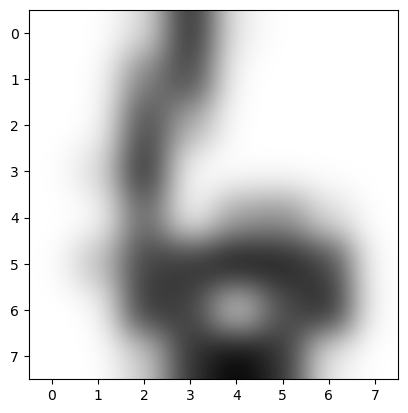

In [11]:
n = np.random.randint(0,data.shape[0])
print('Target:',targets[n])
plt.imshow(images[n],cmap='binary',interpolation='gaussian')
plt.show()

## KNN Classification

In [12]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split as tts

In [13]:
X_train,X_test,y_train,y_test = tts(data,targets,test_size=0.5)

In [14]:
clf = KNN(n_neighbors=10)

In [15]:
clf.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [16]:
clf.predict(X_test[:5])

array([8, 2, 4, 0, 7])

In [17]:
y_test[:5]

array([8, 2, 4, 0, 7])

In [18]:
clf.score(X_test,y_test)

0.9699666295884316

## Classification by OT

Let $x_{(i,j),(k,l)}$ be the decision variables: the amount of pixel intensity moved from pixel $(i,j)$ to $(k,l)$.

Let $c_{(i,j),(k,l)}$ be the cost to move a unit of pixel intensity from pixel $(i,j)$ to $(k,l)$. The cost is proportional to the distance and so we define it as the L2 distance:

$$
c_{(i,j),(k,l)} = \| (i,j) - (k,l)\|
$$

We want to find $x_{(i,j),(k,l)}$ which minimizes the total cost:

$$
\sum_{i,j,k,l} c_{(i,j),(k,l)} x_{(i,j),(k,l)}
$$

Construct the cost matrix:

In [19]:
d = 8
C = np.zeros((d,d,d,d))
for i in range(d):
    for j in range(d):
        for k in range(d):
            for l in range(d):
                C[i,j,k,l] = la.norm([i-k,j-l])

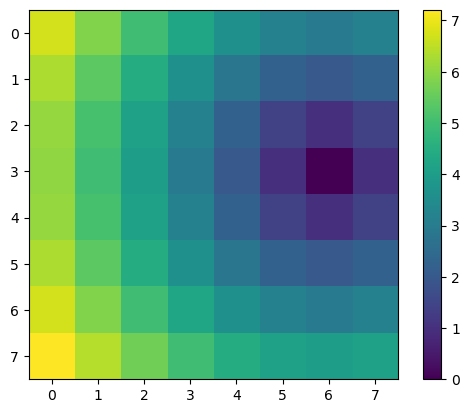

In [20]:
plt.imshow(C[3,6,:,:]), plt.colorbar()
plt.show()

The value of the objective function is the [Wasserstein distance](https://en.wikipedia.org/wiki/Wasserstein_metric):

In [21]:
def distanceOT(s,t):
    s = s/s.sum()
    t = t/t.sum()
    X = cp.Variable((d**2,d**2))
    obj = cp.Minimize(cp.sum(cp.multiply(C.reshape(d**2,d**2),X)))
    constraints = [X >= 0]
    for k in range(d):
        for l in range(d):
            constraints += [cp.sum(X[:,d*k+l]) == t[k,l]]
    for i in range(d):
        for j in range(d):
            constraints += [cp.sum(X[d*i+j,:]) == s[i,j]]
    prob = cp.Problem(obj,constraints)
    return prob.solve()

In [22]:
s = images[0]
t = images[1]
distanceOT(s,t)

0.8287331674215888

In [37]:
s = images[0]
print('Label \t','OT distance','\t\t','L2 distance')
print(50*'-')
for n in range(1,50):
    t = images[n]
    print(targets[n],'\t',distanceOT(s,t),'\t',la.norm(s-t))

Label 	 OT distance 		 L2 distance
--------------------------------------------------
1 	 0.8287331674215888 	 59.55669567731239
2 	 0.8060415806884055 	 54.12947441089743
3 	 0.77523874865398 	 47.57099956906519
4 	 0.9905711827307779 	 50.33885179461288
5 	 0.6639597057035307 	 43.9089968002003
6 	 0.9912958836548649 	 48.55924216871593
7 	 0.9616348774582242 	 56.0
8 	 0.5767548151632065 	 44.395945760846224
9 	 0.5826285847852711 	 40.80441152620633
0 	 0.3136349935599102 	 23.706539182259394
1 	 0.9396502418264132 	 60.423505360083176
2 	 1.04881386899703 	 51.088159097779204
3 	 0.7348746643497723 	 46.03259714593562
4 	 0.6658875805866429 	 46.75467891024384
5 	 0.9305698038767392 	 54.91812087098393
6 	 1.1398873340530764 	 59.724366886556446
7 	 0.6519381022152522 	 47.34976240700686
8 	 0.7018341535625261 	 46.0
9 	 0.9996360656211888 	 50.368641037852115
0 	 0.27320777775695476 	 26.095976701399778
1 	 0.9089229048147223 	 59.59865770300536
2 	 0.8802108758878907 	 50.655700